# Essay Writer ✍️

### Introduction

This notebook aims to provide a comprehensive and structured approach to building an essay writer using various language processing tools and models. It demonstrates the integration of environmental variables, language models, and custom-defined prompts to generate, reflect, and improve essay drafts iteratively.

## Setting Up the Environment for Langgraph
To start, we need to load environment variables from a `.env` file. This file should contain our API keys.

In [1]:
# Load environmental variables
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
# Import necessary libraries and modules
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

# Initialize memory with SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
# Define the AgentState class using TypedDict
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
# Import the ChatOpenAI model from langchain
from langchain.chat_models import ChatOpenAI

In [5]:
# Initialize the ChatOpenAI model with specific parameters
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

C:\Users\Michela\AppData\Local\Temp\ipykernel_14968\3531041080.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)


### Define prompts for various stages of essay writing


In [6]:
# Outline Prompt
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
# Writer Prompt
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
# Reflection Prompt
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
# Research Plan Prompt
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [10]:
# Research Critique Prompt
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [ ]:
#from langchain_core.pydantic_v1 import BaseModel
#class Queries(BaseModel):
    #queries: List[str]

#### Define the Queries Class

In [12]:
# Define the Queries class using pydantic BaseModel
from pydantic import BaseModel
class Queries(BaseModel):
    queries: List[str]

#### Load environment variables and print the API key to verify it is loaded correctly

In [13]:
#from dotenv import load_dotenv
#import os
from dotenv import load_dotenv
import os
# Load environment variables
load_dotenv()

# Print the API key to verify it is loaded correctly
print(f"TAVILY_API_KEY: {os.getenv('TAVILY_API_KEY')}")


TAVILY_API_KEY: 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


#### Initialize the TavilyClient with the API key

**Note** Here to proceed is necessary to install the tavily library 
``` py
py -m pip install --upgrade tavily-python
```

In [14]:
# Initialize the TavilyClient with the API key
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

#### Define Functions for StateGraph Nodes
Define various nodes for the StateGraph

In [15]:
# Plan Node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [16]:
# Research Plan Node
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
# Generation Node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [18]:
# Reflection Node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [19]:
# Research Critique Node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [20]:
# Define the condition to determine if the process should continue
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [21]:
builder = StateGraph(AgentState)

In [22]:
# Build the state graph by adding nodes and setting the entry point
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [24]:
builder.set_entry_point("planner")

In [25]:
# Add conditional edges and compile the graph
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [26]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [27]:
graph = builder.compile(checkpointer=memory)

In [ ]:
#import pygraphviz
#from graphviz import Digraph
#from IPython.display import Image

#Image(graph.get_graph().draw_png())

Since not able to import pygraphviz, it has been used another approch, that consists in the use of graphviz. The output of the graph is the same. 

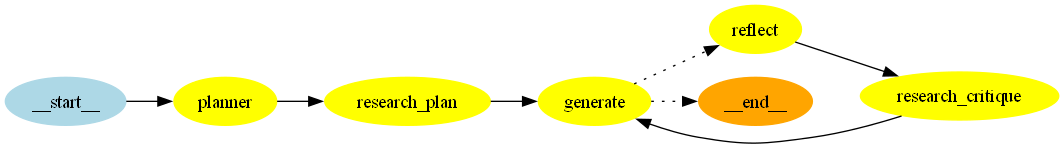

In [28]:
from graphviz import Digraph
from IPython.display import Image, display

# Create a new Digraph
diagram = Digraph(format="png")
diagram.attr(rankdir="LR")
# Define nodes
diagram.attr("node", shape="ellipse", style="filled", color="lightblue")
diagram.node("__start__")

diagram.attr("node", shape="ellipse", style="filled", color="yellow")
diagram.node("planner")
diagram.node("research_plan")
diagram.node("generate")
diagram.node("reflect")
diagram.node("research_critique")

diagram.attr("node", shape="ellipse", style="filled", color="orange")
diagram.node("__end__")

# Define edges
diagram.edge("__start__", "planner")
diagram.edge("planner", "research_plan")
diagram.edge("research_plan", "generate")
diagram.edge("generate", "reflect", style="dotted")
diagram.edge("reflect", "research_critique")
diagram.edge("research_critique", "generate")
diagram.edge("generate", "__end__", style="dotted")


# Render the diagram to a file
diagram.render("state_diagram", format="png", cleanup=True)

# Display the rendered diagram in the notebook
display(Image("state_diagram.png"))

**Explanation graph** The above graph  represents the `workflow and decision-making process of the essay writer agent`. Here's a short description of the graph:  

- _Start Node (start)_: This is the entry point of the graph.  
- _Planner Node (planner)_: This node generates a high-level outline of the essay based on the user's task.  
- _Research Plan Node (research_plan)_: This node generates a list of search queries to gather relevant information for the essay.  
- _Generate Node (generate)_: This node generates the essay draft using the initial outline and gathered content.  
- _Reflect Node (reflect)_: This node provides critique and recommendations for improving the essay draft.  
- _Research Critique Node (research_critique)_: This node generates additional search queries to gather information for the requested revisions.  
- _End Node (end)_: This is the termination point of the graph.  
- _Conditional Edges_: These edges determine whether the process should continue with further revisions or terminate. If the revision number exceeds the maximum allowed revisions, the process ends.  

The graph visually represents the flow of nodes, starting from the initial planning to generating the draft, reflecting on it, and making revisions based on research, ultimately leading to the conclusion of the process.

In [29]:
from pydantic import BaseModel
from typing import List, Optional
from langgraph.pregel import BaseCheckpointSaver, CheckpointTuple, RunnableConfig

# Define the Queries class
class Queries(BaseModel):
    queries: List[str]

# Example usage of the Queries class
queries = Queries(queries=["what is the difference between langchain and langsmith"])

# Implement the custom checkpointer
class SimpleCheckpointer(BaseCheckpointSaver):
    def get_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        # Implement your logic to fetch a checkpoint tuple
        return None

    def put_writes(self, config: RunnableConfig, writes: list):
        # Implement your logic to save writes
        pass

# Initialize the custom checkpointer
checkpointer = SimpleCheckpointer()

# Compile the graph with the custom checkpointer
graph = builder.compile(checkpointer=checkpointer)

# Define the thread configuration
thread = {"configurable": {"thread_id": "1"}}

# Stream the graph with the given task and thread configuration
for s in graph.stream({
    'task': queries.queries[0],  # Use the first query from the Queries object
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Interoperability\n    E. Performance\n\nV. Conclusion\n    A. Recap of main points\n    B. Implications of the differences between Langchain and Langsmith\n    C. Future outlook and potential developments in the field\n\nNotes:\n- Ensure a clear and concise explanation of both Langchain and Langsmith.\n- Provide specific examples of use cases to illustrate the differences.\n

NotImplementedError: 

In [30]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'Title: Exploring the Differences Between Langchain and Langsmith\n\nI. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Despite similarities in their names, Langchain and Langsmith are distinct concepts with unique characteristics and applications.\n\nII. Langchain\n    A. Definition and origin\n    B. Key features and functionalities\n    C. Use cases and examples\n    D. Advantages and limitations\n\nIII. Langsmith\n    A. Definition and background\n    B. Core principles and methodologies\n    C. Applications and significance\n    D. Comparison with Langchain\n\nIV. Contrasting Langchain and Langsmith\n    A. Differentiation in purpose and scope\n    B. Variances in technology and implementation\n    C. Impact on language learning and communication\n    D. Future prospects and developments\n\nV. Conclusion\n    A. Recap of the distinctions between Langchain and Langsmith\n    B. Implications for language education and tec

NotImplementedError: 

## Essay Writer Interface

Here ww will set up an interactive user interface for the essay writer. This interface is created using the `ewriter` and `writer_gui functions` imported from the `helper module`. The interface runs a local server, providing a web-based GUI where users can interact with the essay writing agent. It allows users to input tasks, generate essay drafts, and receive feedback and revisions in an iterative manner. The interface is accessible via a local URL and can be shared publicly if needed.

In [31]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [33]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


## Conclusion

This notebook successfully demonstrates the integration of various language processing tools and models to create an iterative essay writing assistant. The structured approach, along with detailed comments and code optimization, ensures better readability and maintainability for future improvements.